# Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
import keras

# Dataset compiling for binary

In [ ]:
df= pd.read_csv("CICIoT2023.csv",low_memory=False)

In [ ]:
attack = []
for label in df['label']:
    if label == 'BenignTraffic':
        attack.append(0)  # Assign 0 for "BenignTraffic"
    else:
        attack.append(1)  # Assign 1 for any other traffic type

# Create a new column 'traffic_type' and store the results
df['attack'] = attack



In [ ]:
data= df.sample(frac=1).reset_index(drop=True)

In [ ]:
data= data.drop(columns=['label'])

In [ ]:
data.to_csv('CICIoT2023_binary.csv', index=False)

# Loading The Final dataset

In [2]:
dataset= pd.read_csv("CICIoT2023_binary.csv",low_memory=False)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46686579 entries, 0 to 46686578
Data columns (total 47 columns):
 #   Column           Dtype  
---  ------           -----  
 0   flow_duration    float64
 1   Header_Length    float64
 2   Protocol Type    float64
 3   Duration         float64
 4   Rate             float64
 5   Srate            float64
 6   Drate            float64
 7   fin_flag_number  float64
 8   syn_flag_number  float64
 9   rst_flag_number  float64
 10  psh_flag_number  float64
 11  ack_flag_number  float64
 12  ece_flag_number  float64
 13  cwr_flag_number  float64
 14  ack_count        float64
 15  syn_count        float64
 16  fin_count        float64
 17  urg_count        float64
 18  rst_count        float64
 19  HTTP             float64
 20  HTTPS            float64
 21  DNS              float64
 22  Telnet           float64
 23  SMTP             float64
 24  SSH              float64
 25  IRC              float64
 26  TCP              float64
 27  UDP       

# Data Preprocessing

In [9]:
dataset.isna().sum()

flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
attack             0
dtype: int64

In [7]:
dataset.drop_duplicates(subset=None, keep="first", inplace=True)
dataset.duplicated().sum()


0

In [10]:
dataset['attack'].value_counts()

attack
1    45588384
0     1098195
Name: count, dtype: int64

In [ ]:
def encod(data):
  n=data.shape[1]
  from sklearn import preprocessing
  label_encoder = preprocessing.LabelEncoder()
  for i in range(n):
      if data.iloc[:,i].dtype == 'object':
        data.iloc[:,i]= label_encoder.fit_transform(data.iloc[:,i])
  return data

In [ ]:
# Label encoding
dataset=encod(dataset)


In [3]:
dataset.attack.unique()

array([1, 0], dtype=int64)

In [4]:
X=dataset.drop(['attack'],axis=1)
y=dataset['attack']
dataset=0

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X=0
y=0

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
X_train.shape

(37349263, 46)

# Vanilla Autoencoder Model

In [8]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU



# Now any TensorFlow operation will run on the CPU
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)



from keras.layers import Dense, Dropout, Activation

In [26]:
input_dim = X_train.shape[1]

In [13]:
input_vanilla = tf.keras.Input(shape=(input_dim,), name='input_vanilla')
encoded_vanilla = Dense(128, activation='relu', name='encode1_vanilla')(input_vanilla)
encoded_vanilla = Dense(64, activation='relu', name='encode2_vanilla')(encoded_vanilla)
encoded_vanilla = Dense(32, activation='relu', name='latent_vanilla')(encoded_vanilla)

decoded_vanilla = Dense(64, activation='relu', name='decode1_vanilla')(encoded_vanilla)
decoded_vanilla = Dense(128, activation='relu', name='decode2_vanilla')(decoded_vanilla)
output_vanilla = Dense(input_dim, activation='sigmoid', name='output_vanilla')(decoded_vanilla)



In [14]:
vanilla = tf.keras.Model(input_vanilla, output_vanilla)

vanilla.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_vanilla (InputLayer)  [(None, 46)]              0         
                                                                 
 encode1_vanilla (Dense)     (None, 128)               6016      
                                                                 
 encode2_vanilla (Dense)     (None, 64)                8256      
                                                                 
 latent_vanilla (Dense)      (None, 32)                2080      
                                                                 
 decode1_vanilla (Dense)     (None, 64)                2112      
                                                                 
 decode2_vanilla (Dense)     (None, 128)               8320      
                                                                 
 output_vanilla (Dense)      (None, 46)                5934  

In [15]:
vanilla.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
#EarlyStopping callback
early_stopping_callback= keras.callbacks.EarlyStopping(monitor='loss',patience=6,baseline=None,restore_best_weights=True)

# model_checkpoint_callback
checkpoint_filepath = 'vanillamodel_CICIoT2023.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='loss',mode='min',save_best_only=True)

callbacks = [early_stopping_callback, model_checkpoint_callback]
#train with both callbacks
history=vanilla.fit(X_train, X_train,epochs=100,batch_size=32, callbacks=[callbacks],verbose=1)

print("Number of epochs run:", len(history.history['loss']))



Epoch 1/100
1167165/1167165 [==============================] - 3795s 3ms/step - loss: 5.6386e-05
Epoch 2/100
1167165/1167165 [==============================] - 3928s 3ms/step - loss: 2.4193e-05
Epoch 3/100
1167165/1167165 [==============================] - 3980s 3ms/step - loss: 2.4356e-05
Epoch 4/100
1167165/1167165 [==============================] - 4024s 3ms/step - loss: 2.7466e-05
Epoch 5/100
1167165/1167165 [==============================] - 4045s 3ms/step - loss: 3.5963e-05
Epoch 6/100
1167165/1167165 [==============================] - 4011s 3ms/step - loss: 2.7796e-05
Epoch 7/100
1167165/1167165 [==============================] - 4046s 3ms/step - loss: 2.6562e-05
Epoch 8/100
1167165/1167165 [==============================] - 4062s 3ms/step - loss: 6.6699e-05
Number of epochs run: 8


In [17]:
vanilla.evaluate(X_test,X_test)

291792/291792 [==============================] - 381s 1ms/step - loss: 2.2817e-05


2.28169810725376e-05

In [18]:
for layer in vanilla.layers:
    layer.trainable =False

vanilla.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_vanilla (InputLayer)  [(None, 46)]              0         
                                                                 
 encode1_vanilla (Dense)     (None, 128)               6016      
                                                                 
 encode2_vanilla (Dense)     (None, 64)                8256      
                                                                 
 latent_vanilla (Dense)      (None, 32)                2080      
                                                                 
 decode1_vanilla (Dense)     (None, 64)                2112      
                                                                 
 decode2_vanilla (Dense)     (None, 128)               8320      
                                                                 
 output_vanilla (Dense)      (None, 46)                5934  

# Variational Autoencoder Model

In [27]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Concatenate
from tensorflow.keras.losses import mse

from keras import layers

In [28]:
class Sampling(layers.Layer):
	"""Uses (mean, log_var) to sample z, the vector encoding a digit."""

	def call(self, inputs):
		mean, log_var = inputs
		batch = tf.shape(mean)[0]
		dim = tf.shape(mean)[1]
		epsilon = tf.random.normal(shape=(batch, dim))
		return mean + tf.exp(0.5 * log_var) * epsilon


In [29]:
latent_dim = 16
#encoder
encoder_inputs = keras.Input(shape=(input_dim,),name='encoder_input')
x = layers.Dense(128, activation="relu",name="encoder1")(encoder_inputs)
x = layers.Dense(64, activation="relu",name="enocder2")(x)
x = layers.Dense(32, activation="relu",name="encoder_latent_vae")(x)
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)
z = Sampling()([mean, log_var])

encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
encoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 46)]         0           []                               
                                                                                                  
 encoder1 (Dense)               (None, 128)          6016        ['encoder_input[0][0]']          
                                                                                                  
 enocder2 (Dense)               (None, 64)           8256        ['encoder1[0][0]']               
                                                                                                  
 encoder_latent_vae (Dense)     (None, 32)           2080        ['enocder2[0][0]']               
                                                                                            

In [30]:
#decoder

latent_inputs = keras.Input(shape=(latent_dim,),name='decoder_input')
x = layers.Dense(32, activation="relu",name="decoder1_vae")(latent_inputs)
x = layers.Dense(64, activation="relu", name="decoder2_vae")(x)
x = layers.Dense(128, activation="relu", name="decoder3_vae")(x)
decoder_outputs = layers.Dense(input_dim, activation="sigmoid", name='decoder_output')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 decoder1_vae (Dense)        (None, 32)                544       
                                                                 
 decoder2_vae (Dense)        (None, 64)                2112      
                                                                 
 decoder3_vae (Dense)        (None, 128)               8320      
                                                                 
 decoder_output (Dense)      (None, 46)                5934      
                                                                 
Total params: 16,910
Trainable params: 16,910
Non-trainable params: 0
_________________________________________________________________


In [31]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
# for training a defining and training a VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.optimizer = tf.keras.optimizers.Adam()

    def train_step(self, data):
        data = tf.convert_to_tensor(data)
        with tf.GradientTape() as tape:
            mean, log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(MeanSquaredError()(data, reconstruction)) * data.shape[1]
            
            kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=-1)
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]



In [33]:
#instance of the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer=vae.optimizer)


In [34]:
vae.encoder.summary(),vae.decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 46)]         0           []                               
                                                                                                  
 encoder1 (Dense)               (None, 128)          6016        ['encoder_input[0][0]']          
                                                                                                  
 enocder2 (Dense)               (None, 64)           8256        ['encoder1[0][0]']               
                                                                                                  
 encoder_latent_vae (Dense)     (None, 32)           2080        ['enocder2[0][0]']               
                                                                                            

(None, None)

In [35]:
#EarlyStopping callback
early_stopping_callback= keras.callbacks.EarlyStopping(monitor='loss',patience=6,baseline=None,restore_best_weights=True)

# model_checkpoint_callback
checkpoint_filepath = 'variaAEmodel_CICIoT2023.keras'

callbacks = [early_stopping_callback]
#train with both callbacks
history=vae.fit(X_train,epochs=100,batch_size=32,callbacks=[callbacks],verbose=1)

print("Number of epochs run:", len(history.history['loss']))
print("Available keys in history:", history.history.keys())


Epoch 1/100
1167165/1167165 [==============================] - 4229s 4ms/step - loss: 1.2906 - reconstruction_loss: 1.2886 - kl_loss: 4.6798e-06
Epoch 2/100
1167165/1167165 [==============================] - 4341s 4ms/step - loss: 1.2882 - reconstruction_loss: 1.2883 - kl_loss: 1.9078e-09
Epoch 3/100
1167165/1167165 [==============================] - 4325s 4ms/step - loss: 1.2885 - reconstruction_loss: 1.2883 - kl_loss: 1.9405e-09
Epoch 4/100
1167165/1167165 [==============================] - 4237s 4ms/step - loss: 1.2883 - reconstruction_loss: 1.2883 - kl_loss: 2.2701e-09
Epoch 5/100
1167165/1167165 [==============================] - 4234s 4ms/step - loss: 1.2883 - reconstruction_loss: 1.2883 - kl_loss: 2.4536e-09
Epoch 6/100
1167165/1167165 [==============================] - 4274s 4ms/step - loss: 1.2884 - reconstruction_loss: 1.2883 - kl_loss: 2.5273e-09
Epoch 7/100
1167165/1167165 [==============================] - 4272s 4ms/step - loss: 1.2882 - reconstruction_loss: 1.2884 - kl_lo

In [36]:
vae.encoder.save('encoder_CICIoT2023.keras')

In [37]:
vae.decoder.save('decoder_CICIoT2023.keras')

In [38]:
vae.encoder.get_layer('sampling').output

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'sampling')>

In [39]:
a,b,encoded=vae.encoder.predict(X_test)

291792/291792 [==============================] - 430s 1ms/step


In [40]:
decoded=vae.decoder.predict(encoded)

291792/291792 [==============================] - 1261s 4ms/step


In [41]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X_test, decoded)

0.028015044173615666

In [42]:
for layer in vae.encoder.layers:
    layer.trainable = False
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 46)]         0           []                               
                                                                                                  
 encoder1 (Dense)               (None, 128)          6016        ['encoder_input[0][0]']          
                                                                                                  
 enocder2 (Dense)               (None, 64)           8256        ['encoder1[0][0]']               
                                                                                                  
 encoder_latent_vae (Dense)     (None, 32)           2080        ['enocder2[0][0]']               
                                                                                            

In [43]:
vae.encoder.get_layer('sampling').output

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'sampling')>

# Combined latent_space and creating a decoder

In [44]:

VAE_input = vae.encoder.input
VAE_output = vae.encoder.get_layer('sampling').output

VaAE_input = vanilla.input
VaAE_output = vanilla.get_layer('latent_vanilla').output

combined = Concatenate(name='combined')([VAE_output, VaAE_output])

l = Dense(128, activation='relu', name='combined1')(combined)
l = Dense(64, activation='relu', name='combined2')(l)
l = Dense(32, activation='relu', name='combined3')(l)
output_combined= Dense(1, activation='sigmoid', name='combined_output')(l)


combined_model = tf.keras.Model([VAE_input, VaAE_input], output_combined)


In [45]:
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 46)]         0           []                               
                                                                                                  
 encoder1 (Dense)               (None, 128)          6016        ['encoder_input[0][0]']          
                                                                                                  
 enocder2 (Dense)               (None, 64)           8256        ['encoder1[0][0]']               
                                                                                                  
 input_vanilla (InputLayer)     [(None, 46)]         0           []                               
                                                                                              

In [46]:
combined_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [47]:
#EarlyStopping callback
early_stopping_callback= keras.callbacks.EarlyStopping(monitor='val_loss',patience=6,baseline=None,restore_best_weights=True)

# model_checkpoint_callback
checkpoint_filepath = 'combinedmodel_CICIoT2023.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_loss',mode='min',save_best_only=True)


callbacks = [early_stopping_callback, model_checkpoint_callback]
#train with both callbacks
history=combined_model.fit([X_train,X_train],y_train,epochs=100,batch_size=32,validation_split=0.2,callbacks=[callbacks],verbose=1)

print("Number of epochs run:", len(history.history['val_loss']))

Epoch 1/100
933732/933732 [==============================] - 17083s 18ms/step - loss: 0.0183 - accuracy: 0.9938 - val_loss: 0.0212 - val_accuracy: 0.9919
Epoch 2/100
933732/933732 [==============================] - 16575s 18ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0.0182 - val_accuracy: 0.9923
Epoch 3/100
933732/933732 [==============================] - 15635s 17ms/step - loss: 0.0380 - accuracy: 0.9865 - val_loss: 0.0317 - val_accuracy: 0.9855
Epoch 4/100
933732/933732 [==============================] - 17703s 19ms/step - loss: 0.0605 - accuracy: 0.9828 - val_loss: 0.0795 - val_accuracy: 0.9764
Epoch 5/100
933732/933732 [==============================] - 19495s 21ms/step - loss: 0.0856 - accuracy: 0.9792 - val_loss: 0.0804 - val_accuracy: 0.9764
Epoch 6/100
933732/933732 [==============================] - 21035s 23ms/step - loss: 0.0802 - accuracy: 0.9791 - val_loss: 0.0804 - val_accuracy: 0.9764
Epoch 7/100
933732/933732 [==============================] - 21212s 23ms/ste

In [48]:
combined_model.evaluate([X_test,X_test],y_test)

291792/291792 [==============================] - 2991s 10ms/step - loss: 0.0182 - accuracy: 0.9923


[0.01817641779780388, 0.9923224449157715]

In [49]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
y_pred_prob = combined_model.predict([X_test, X_test])
y_pred = (y_pred_prob > 0.5).astype(int)

291792/291792 [==============================] - 2644s 9ms/step


In [51]:
cm = confusion_matrix(y_test, y_pred)


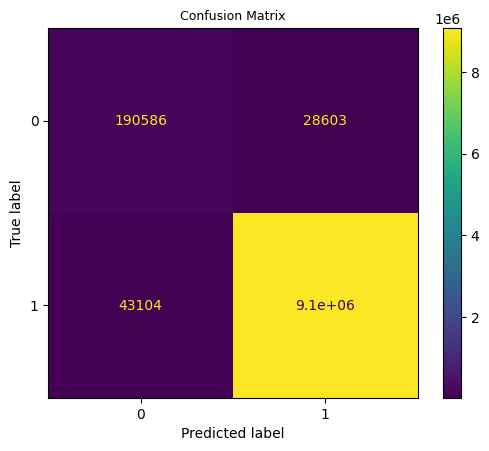

In [52]:
cm = ConfusionMatrixDisplay(cm)
cm.plot()
plt.title('Confusion Matrix',fontsize=9)
plt.show()

In [53]:
print(classification_report(y_test, y_pred,digits=5))

              precision    recall  f1-score   support

           0    0.81555   0.86951   0.84166    219189
           1    0.99686   0.99527   0.99606   9118127

    accuracy                        0.99232   9337316
   macro avg    0.90620   0.93239   0.91886   9337316
weighted avg    0.99260   0.99232   0.99244   9337316



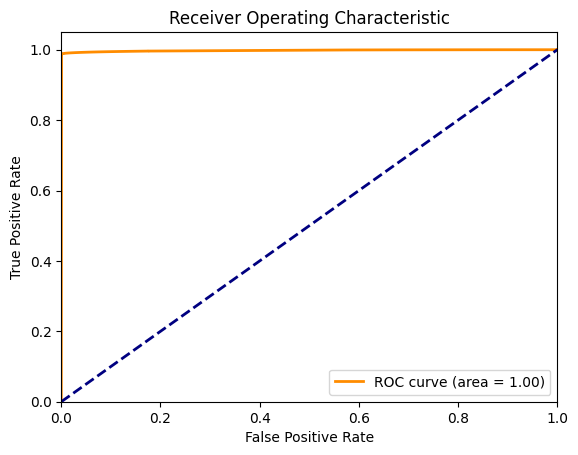

In [54]:
from sklearn.metrics import roc_curve, auc,matthews_corrcoef
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [55]:
mcc = matthews_corrcoef(y_test, y_pred)


In [56]:

print("Matthews Correlation Coefficient:", mcc)


Matthews Correlation Coefficient: 0.8381844002842069


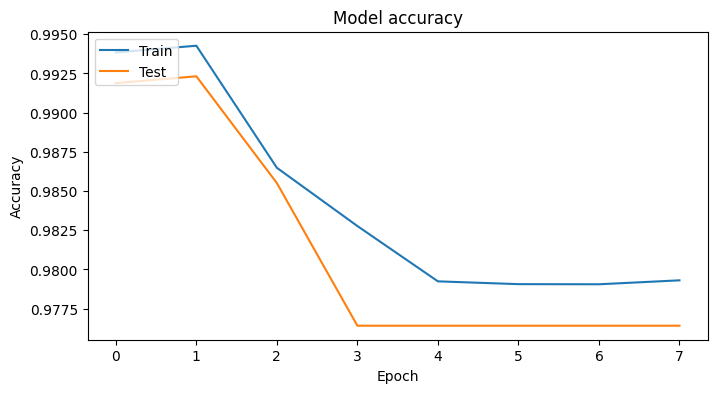

In [57]:
# Plot training & validation accuracy values
plt.figure(figsize= (8, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

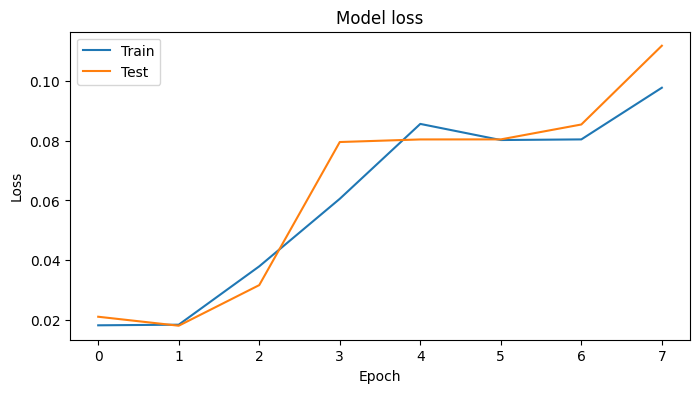

In [58]:
# Plot training & validation loss values
plt.figure(figsize= (8, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

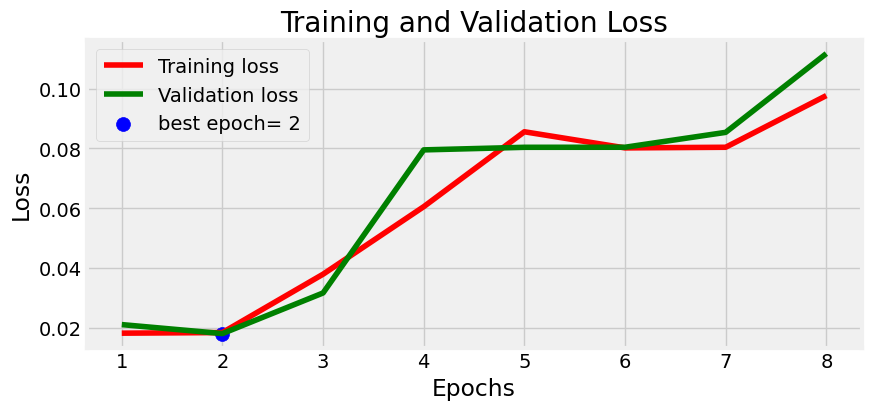

In [59]:
tr_loss = history.history['loss']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

Epochs = [i+1 for i in range(len(tr_loss))]
loss_label = f'best epoch= {str(index_loss + 1)}'

# Plot training history
plt.figure(figsize= (10, 4))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 100, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()